In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Neural_Tangent_Kernel/

/content/drive/MyDrive/Neural_Tangent_Kernel


In [3]:
import numpy as np
import pandas as pd

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from matplotlib import pyplot as plt


from myrmsprop import MyRmsprop
from utils import plot_decision_boundary,attn_avg,plot_analysis
from synthetic_dataset import MosaicDataset1
from eval_model import calculate_attn_loss,analyse_data



%matplotlib inline
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
train_data = np.load("train_type4_data.npy",allow_pickle=True)

test_data = np.load("test_type4_data.npy",allow_pickle=True)

In [5]:
mosaic_list_of_images = train_data[0]["mosaic_list"]
mosaic_label = train_data[0]["mosaic_label"]
fore_idx = train_data[0]["fore_idx"]


test_mosaic_list_of_images = test_data[0]["mosaic_list"]
test_mosaic_label = test_data[0]["mosaic_label"]
test_fore_idx = test_data[0]["fore_idx"]

In [6]:
batch = 250
train_dataset = MosaicDataset1(mosaic_list_of_images, mosaic_label, fore_idx)
train_loader = DataLoader( train_dataset,batch_size= batch ,shuffle=False)
#batch = 2000
#test_dataset = MosaicDataset1(test_mosaic_list_of_images, test_mosaic_label, test_fore_idx)
#test_loader = DataLoader(test_dataset,batch_size= batch ,shuffle=False)

In [7]:
n_batches = 3000//batch
bg = []
for i in range(n_batches):
  torch.manual_seed(i)
  betag =  torch.randn(batch,9) #torch.ones((250,9))/9
  bg.append( betag.requires_grad_() )

In [8]:
 bg

[tensor([[-1.1258, -1.1524, -0.2506,  ..., -0.3160, -2.1152,  0.3223],
         [-1.2633,  0.3500,  0.3081,  ..., -0.2473, -1.3527, -1.6959],
         [ 0.5667,  0.7935,  0.5988,  ...,  0.7502, -0.5855, -0.1734],
         ...,
         [ 0.8374, -0.7942, -0.3622,  ...,  0.0121,  0.8032, -0.6962],
         [-1.0645,  0.2384, -0.3385,  ...,  0.9635, -1.0340,  0.1894],
         [ 0.8253,  1.1038, -1.2491,  ..., -0.5940, -1.7125,  0.3617]],
        requires_grad=True),
 tensor([[-1.5256, -0.7502, -0.6540,  ..., -0.9798, -1.6091, -0.7121],
         [ 0.3037, -0.7773, -0.2515,  ...,  0.4676, -0.6970, -1.1608],
         [ 0.6995,  0.1991,  0.8657,  ...,  1.1017, -0.1759, -2.2456],
         ...,
         [-0.4302,  0.1508,  0.6937,  ...,  0.0314,  2.6645,  0.1189],
         [ 1.4484, -0.0213, -1.3367,  ...,  0.6279, -1.4719, -1.0291],
         [ 0.9081, -1.2433,  1.6062,  ..., -0.1177, -0.5548, -0.0595]],
        requires_grad=True),
 tensor([[-1.0408,  0.9166, -1.3042,  ..., -1.0574, -0.1188,

In [9]:
class Module2(nn.Module):
  def __init__(self):
    super(Module2, self).__init__()
    self.linear1 = nn.Linear(2,100)
    self.linear2 = nn.Linear(100,3)

  def forward(self,x):
    x = F.relu(self.linear1(x))
    x = self.linear2(x)
    return x

In [10]:
torch.manual_seed(1234)
what_net = Module2().double()

what_net.load_state_dict(torch.load("type4_what_net.pt"))
what_net = what_net.to("cuda")

In [11]:
# for param in what_net.parameters():
#     param.requires_grad = False

In [12]:
optim1 = []
for i in range(n_batches):
  optim1.append(optim.RMSprop([bg[i]],lr=10))

In [13]:
# instantiate optimizer
optimizer_what = optim.RMSprop(what_net.parameters(), lr=0.001)#, momentum=0.9)#,nesterov=True)


 


criterion = nn.CrossEntropyLoss()
acti = []
analysis_data_tr = []
analysis_data_tst = []
loss_curi_tr = []
loss_curi_tst = []
epochs = 200


# calculate zeroth epoch loss and FTPT values  

# call to calculate_attn_loss need to make sure batch size is correct in utils file
running_loss,anlys_data,correct,total,accuracy = calculate_attn_loss(train_loader,bg,what_net,criterion)
print('training epoch: [%d ] loss: %.3f correct: %.3f, total: %.3f, accuracy: %.3f' %(0,running_loss,correct,total,accuracy)) 
loss_curi_tr.append(running_loss)
analysis_data_tr.append(anlys_data)




# training starts 
for epoch in range(epochs): # loop over the dataset multiple times
  ep_lossi = []
  running_loss = 0.0
  what_net.train()
  for i, data in enumerate(train_loader, 0):
    # get the inputs
    inputs, labels,_  = data
    inputs = inputs.double()
    beta = bg[i] # alpha for ith batch
    #print(labels)
    inputs, labels,beta = inputs.to("cuda"),labels.to("cuda"),beta.to("cuda")
        
    # zero the parameter gradients
    optimizer_what.zero_grad()
    optim1[i].zero_grad()
      
    # forward + backward + optimize
    avg,alpha = attn_avg(inputs,beta)
    outputs = what_net(avg)     
    loss = criterion(outputs, labels)

    # print statistics
    running_loss += loss.item()
    #alpha.retain_grad()
    loss.backward(retain_graph=False)
    optimizer_what.step()
    optim1[i].step()


  running_loss_tr,anls_data,correct,total,accuracy = calculate_attn_loss(train_loader,bg,what_net,criterion)
  analysis_data_tr.append(anls_data)
  loss_curi_tr.append(running_loss_tr)   #loss per epoch
  print('training epoch: [%d ] loss: %.3f correct: %.3f, total: %.3f, accuracy: %.3f' %(epoch+1,running_loss_tr,correct,total,accuracy)) 


  
  if running_loss_tr<=0.08:
    break
print('Finished Training run ')
analysis_data_tr = np.array(analysis_data_tr)



training epoch: [0 ] loss: 10.382 correct: 1101.000, total: 3000.000, accuracy: 0.367
training epoch: [1 ] loss: 1.754 correct: 2109.000, total: 3000.000, accuracy: 0.703
training epoch: [2 ] loss: 0.184 correct: 2871.000, total: 3000.000, accuracy: 0.957
training epoch: [3 ] loss: 0.112 correct: 2913.000, total: 3000.000, accuracy: 0.971
training epoch: [4 ] loss: 0.106 correct: 2923.000, total: 3000.000, accuracy: 0.974
training epoch: [5 ] loss: 0.103 correct: 2923.000, total: 3000.000, accuracy: 0.974
training epoch: [6 ] loss: 0.101 correct: 2924.000, total: 3000.000, accuracy: 0.975
training epoch: [7 ] loss: 0.097 correct: 2926.000, total: 3000.000, accuracy: 0.975
training epoch: [8 ] loss: 0.095 correct: 2926.000, total: 3000.000, accuracy: 0.975
training epoch: [9 ] loss: 0.091 correct: 2927.000, total: 3000.000, accuracy: 0.976
training epoch: [10 ] loss: 0.090 correct: 2927.000, total: 3000.000, accuracy: 0.976
training epoch: [11 ] loss: 0.089 correct: 2929.000, total: 300

In [14]:
columns = ["epochs", "argmax > 0.5" ,"argmax < 0.5", "focus_true_pred_true", "focus_false_pred_true", "focus_true_pred_false", "focus_false_pred_false" ]
df_train = pd.DataFrame()
df_test = pd.DataFrame()
df_train[columns[0]] = np.arange(0,epoch+2)
df_train[columns[1]] = analysis_data_tr[:,-2]/30
df_train[columns[2]] = analysis_data_tr[:,-1]/30
df_train[columns[3]] = analysis_data_tr[:,0]/30
df_train[columns[4]] = analysis_data_tr[:,1]/30
df_train[columns[5]] = analysis_data_tr[:,2]/30
df_train[columns[6]] = analysis_data_tr[:,3]/30

In [15]:
df_train

,epochs,argmax > 0.5,argmax < 0.5,focus_true_pred_true,focus_false_pred_true,focus_true_pred_false,focus_false_pred_false
0,0,10.066667,89.933333,5.033333,31.666667,5.466667,57.833333
1,1,47.500000,52.500000,13.033333,57.266667,4.566667,25.133333
2,2,81.666667,18.333333,20.633333,75.066667,0.600000,3.700000
3,3,86.633333,13.366667,20.300000,76.800000,0.466667,2.433333
4,4,87.900000,12.100000,20.766667,76.666667,0.466667,2.100000
5,5,88.433333,11.566667,20.866667,76.566667,0.466667,2.100000
6,6,89.033333,10.966667,20.866667,76.600000,0.466667,2.066667
7,7,89.200000,10.800000,21.100000,76.433333,0.466667,2.000000
8,8,89.566667,10.433333,21.100000,76.433333,0.466667,2.000000
9,9,89.666667,10.333333,21.200000,76.366667,0.466667,1.966667


/content


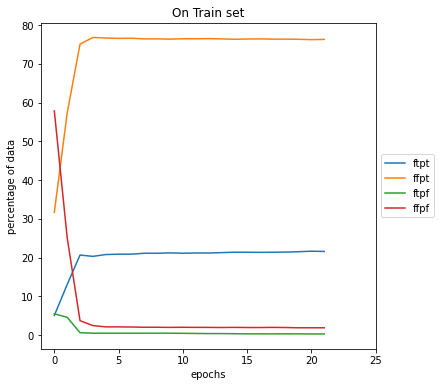

In [21]:
%cd /content/
plot_analysis(df_train,columns,[0,5,10,15,20,25])

In [17]:
aph = []
for i in bg:
  aph.append(F.softmax(i,dim=1).detach().numpy())
aph = np.concatenate(aph,axis=0)
# torch.save({
#             'epoch': 500,
#             'model_state_dict': what_net.state_dict(),
#             #'optimizer_state_dict': optimizer_what.state_dict(),
#             "optimizer_alpha":optim1,
#             "FTPT_analysis":analysis_data_tr,
#             "alpha":aph

#             }, "type4_what_net_500.pt")

In [18]:
aph[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32)

In [19]:
avrg = []
avrg_lbls = []
with torch.no_grad():
  for i, data in  enumerate(train_loader):
          inputs , labels , fore_idx = data
          inputs = inputs.double()
          inputs = inputs.to("cuda")
          beta  = bg[i]
          beta = beta.to("cuda")
          avg,alpha = attn_avg(inputs,beta)
          
          avrg_lbls.append(labels.numpy())
          avrg.append(avg.detach().cpu().numpy())
avrg= np.concatenate(avrg,axis=0)
avrg_lbls = np.concatenate(avrg_lbls,axis=0)

/content/drive/MyDrive/Neural_Tangent_Kernel
/content


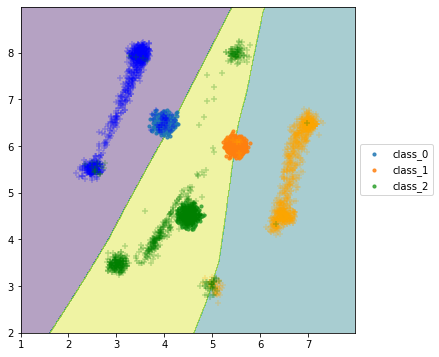

In [20]:
%cd /content/drive/MyDrive/Neural_Tangent_Kernel/
data = np.load("type_4_data.npy",allow_pickle=True)
%cd /content/
plot_decision_boundary(what_net,[1,8,2,9],data,bg,avrg,avrg_lbls)